<a href="https://colab.research.google.com/github/JasminPradhan/OralCancerDetection/blob/main/OralCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow opencv-python matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from keras.applications import *
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, BatchNormalization,GlobalMaxPooling2D
import cv2
import os
import sys
import pickle

In [4]:

gpus=tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [6]:
DATADIR="/content/drive/MyDrive/data/cancer/"

batch = 32
classes = 'binary'

train_path=os.path.join(DATADIR,'train')
test_path=os.path.join(DATADIR,'test')
val_path=os.path.join(DATADIR,'val')

In [7]:
# Define the image data generators
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_datagen= image.ImageDataGenerator()

test_datagen= image.ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = batch,
    class_mode = classes
    )


validation_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size = (224,224),
    batch_size = batch,
    shuffle=True,
    class_mode = classes)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = batch,
    class_mode = classes)

# Get the class names
class_names=validation_generator.class_indices
class_names
len(class_names)

Found 4946 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


2

In [8]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''


    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)


    l = len(labels)
    min_len = min(l, 25)

    plt.figure(figsize= (20, 20))

    for i in range(min_len):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

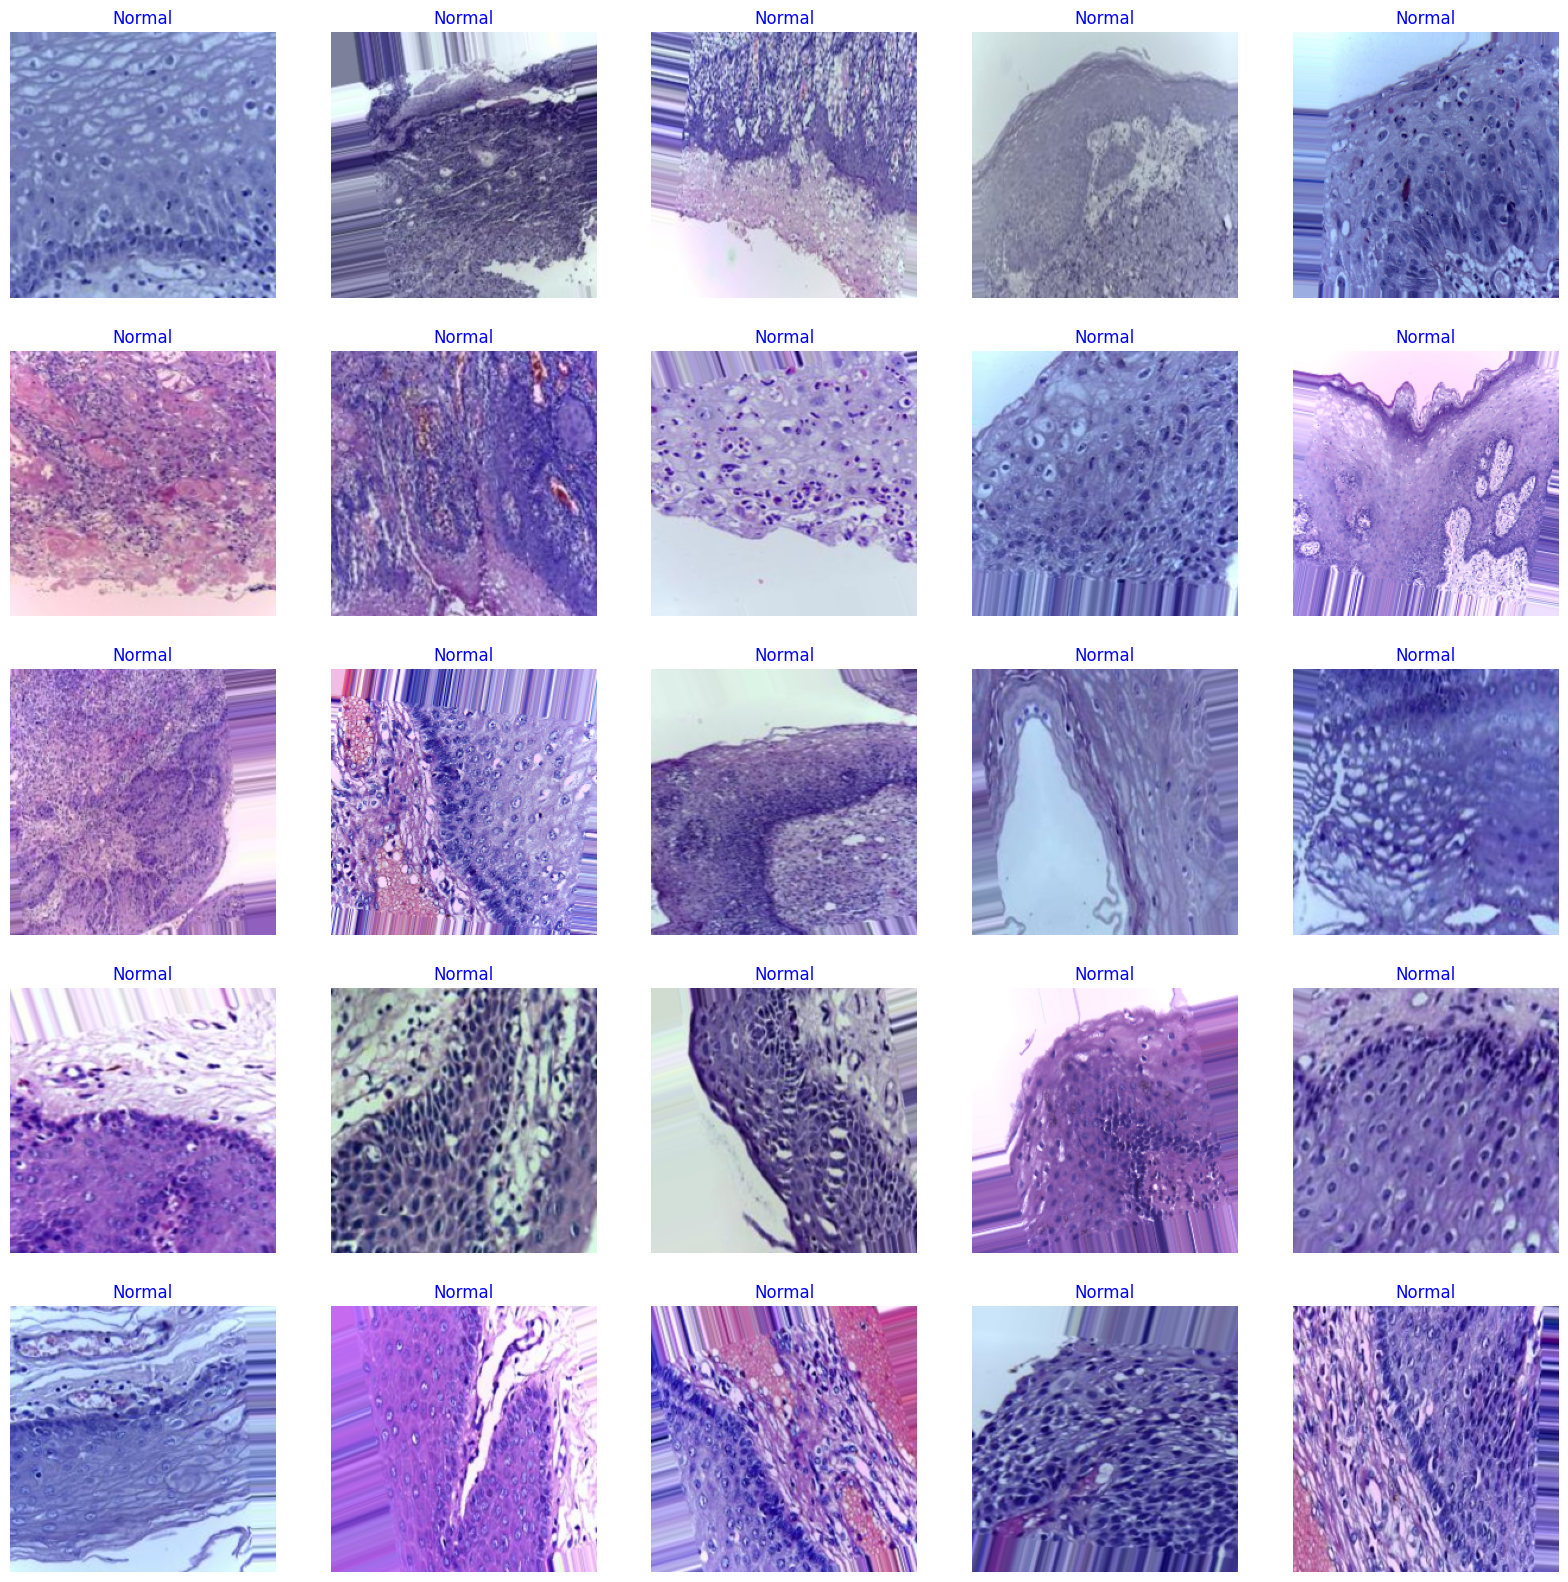

In [9]:
show_images(train_generator)

In [10]:
# train_generator = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# test_generator = test_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_generator = val_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [11]:
# Setting the base model
base_for_model = tf.keras.applications.VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
for layer in base_for_model.layers:
    layer.trainable = False


58889256/58889256 [==============================] - 0s 0us/step


In [12]:
# Build the model architecture
model = Sequential([
    base_for_model,
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(512, activation='relu'),
    GlobalMaxPooling2D(),
    BatchNormalization(),
    Dense(512, activation = 'relu'),
    BatchNormalization(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dense (Dense)               (None, 7, 7, 512)         262656    
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 7, 7, 512)         262656    
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2

In [13]:
# Define the F1 score metric
def f1_score_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    return 2 * tf.reduce_sum(y_true * y_pred) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())


In [14]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy','Precision','Recall','AUC',f1_score_metric]
)

In [15]:
# Train the model
model.fit(
    train_generator,
    epochs=10,
    batch_size=64,
    validation_data=validation_generator
)

Epoch 1/10
155/155 [==============================] - 1204s 7s/step - loss: 0.6286 - accuracy: 0.7149 - precision: 0.7219 - recall: 0.7133 - auc: 0.7839 - f1_score_metric: 0.7154 - val_loss: 0.7275 - val_accuracy: 0.7250 - val_precision: 0.8471 - val_recall: 0.7826 - val_auc: 0.7461 - val_f1_score_metric: 0.8141
Epoch 2/10
155/155 [==============================] - 143s 926ms/step - loss: 0.4050 - accuracy: 0.8184 - precision: 0.8288 - recall: 0.8096 - auc: 0.9003 - f1_score_metric: 0.8163 - val_loss: 0.6088 - val_accuracy: 0.7667 - val_precision: 0.8556 - val_recall: 0.8370 - val_auc: 0.7760 - val_f1_score_metric: 0.8446
Epoch 3/10
155/155 [==============================] - 139s 899ms/step - loss: 0.3472 - accuracy: 0.8474 - precision: 0.8578 - recall: 0.8383 - auc: 0.9256 - f1_score_metric: 0.8457 - val_loss: 0.3887 - val_accuracy: 0.8583 - val_precision: 0.8571 - val_recall: 0.9783 - val_auc: 0.8960 - val_f1_score_metric: 0.9100
Epoch 4/10
155/155 [==============================] - 

In [16]:
score=model.evaluate(validation_generator)
score

4/4 [==============================] - 7s 2s/step - loss: 0.4288 - accuracy: 0.8583 - precision: 0.8866 - recall: 0.9348 - auc: 0.8703 - f1_score_metric: 0.9059


[0.42879408597946167,
 0.8583333492279053,
 0.8865979313850403,
 0.9347826242446899,
 0.8703416585922241,
 0.9058692455291748]

In [17]:
pickle.dump(model, open('OralCancer2.pkl','wb'))